# ТЗ:

Необходимо собрать отчет по некому приложению и автоматизировать его отправку (отчет должен приходить ежедневно в 11:00 в чат). 

В отчете должны быть следующие части:
- текстовая
- графическая
- документная


In [1]:
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import pandahouse
import loggins_and_passwords as connect
from IPython.display import display

Сначала запрототипируем отчет, а потом автоматизируем его отправку с помощью GitLab CI\CD 

В отчете будем показывать:

- dau ленты новостей
    - кол-во просмотренных постов
    - кол-во лайков
    - разбивка по системам и источникам трафика
    - CTR по всем разбивкам
    - количество просмотренных постов
    
- dau сообщений
    - кол-во отправленных сообщений
    - распределение отправленных сообщений по часам
- dau двух сервисов
    - кол-во пользователей использующих оба сервиса


In [2]:
connection = {
    'host': connect.host,         #os.environ.get("db_host"),
    'password': connect.password, #os.environ.get("db_password"),
    'user': connect.user          #os.environ.get("db_login")
}

def db_to_dataframe(query, connection):
    """
    db_to_dataframe(query, connection=connection)
    возвращает объект DataFrame выгруженный из базы.
    Параметры подключения к базе определены в переменной connection
    """
    return pandahouse.read_clickhouse(query, connection=connection)


In [141]:
query = '''
with msg_users as(
    SELECT 
        DISTINCT user_id,
        CAST(time as DATE) day
    From simulator_20220420.message_actions),

feed_users as(
    SELECT 
        DISTINCT user_id user_id,
        CAST(time as DATE) day
    FROM simulator_20220420.feed_actions),
        
using_all AS(
    SELECT 
        t1.day day,
        COUNT (t2.user_id) cnt_using_all
    FROM msg_users as t1
    INNER JOIN feed_users as t2 ON (t1.user_id =t2.user_id
                                      and t1.day=t2.day)
    GROUP BY day
    ORDER BY day ASC),

using_msg_only as(
    SELECT 
        t1.day day,
        COUNT (t1.user_id) cnt_using_only_msg
    FROM msg_users as t1
    LEFT JOIN feed_users as t2 ON (t1.user_id =t2.user_id
                                     and t1.day=t2.day)
    WHERE t2.day = '1970-01-01'
    GROUP BY day
    ORDER BY day ASC),

using_feed_only as(
    SELECT 
        t2.day day,
        COUNT (t2.user_id) cnt_using_only_feed
    FROM msg_users as t1
    RIGHT  JOIN feed_users as t2 ON (t1.user_id =t2.user_id
                                       and t1.day=t2.day)
    WHERE t1.day = '1970-01-01'
    GROUP BY day
    ORDER BY day ASC) 

SELECT
tb2.*,
tb1.using_all_products,
tb1.using_only_msg,
tb1.using_only_feed
FROM    
(SELECT 
    using_all.day day,
    using_all.cnt_using_all using_all_products,
    using_msg_only.cnt_using_only_msg using_only_msg,
    using_feed_only.cnt_using_only_feed using_only_feed
FROM using_all
left join using_msg_only ON using_all.day = using_msg_only.day
LEFT JOIN using_feed_only ON using_all.day = using_feed_only.day
WHERE 
    toStartOfDay(toDateTime(day))<toStartOfDay(now())

Order By day desc)tb1
LEFT JOIN
(
select
t1.*,
t2.cnt_msg_users,
t2.cnt_send_msg,
t2.avg_msg_per_user
FROM
(SELECT 
   CAST(toStartOfDay(toDateTime(time)) as DATE) AS day,
   count(Distinct user_id) AS cnt_feed_users,
   countIf(user_id, action='like') AS likes,
   countIf(user_id, action='view') AS views,
   likes/views*100 as ctr,
   likes/cnt_feed_users avg_likes_per_user,
   views/cnt_feed_users avg_views_per_user
FROM 
    simulator_20220420.feed_actions
WHERE 
    toStartOfDay(toDateTime(time))<toStartOfDay(now())

GROUP BY
    toStartOfDay(toDateTime(time))
ORDER BY day DESC
)t1
left join 
(
SELECT
CAST (toStartOfDay(time) as DATE) day,
count(DISTINCT user_id) cnt_msg_users,
count(user_id) cnt_send_msg,
cnt_send_msg/cnt_msg_users avg_msg_per_user
FROM simulator_20220420.message_actions
WHERE 
    toStartOfDay(toDateTime(time))<toStartOfDay(now())
GROUP BY
    day
ORDER BY day desc
)t2 
USING day
)tb2
USING day

'''

df_all = db_to_dataframe(query, connection).rename(columns={'tb2.day':'day'})
df = df_all.head(7).copy()

<AxesSubplot:title={'center':'avarage messages per user'}>

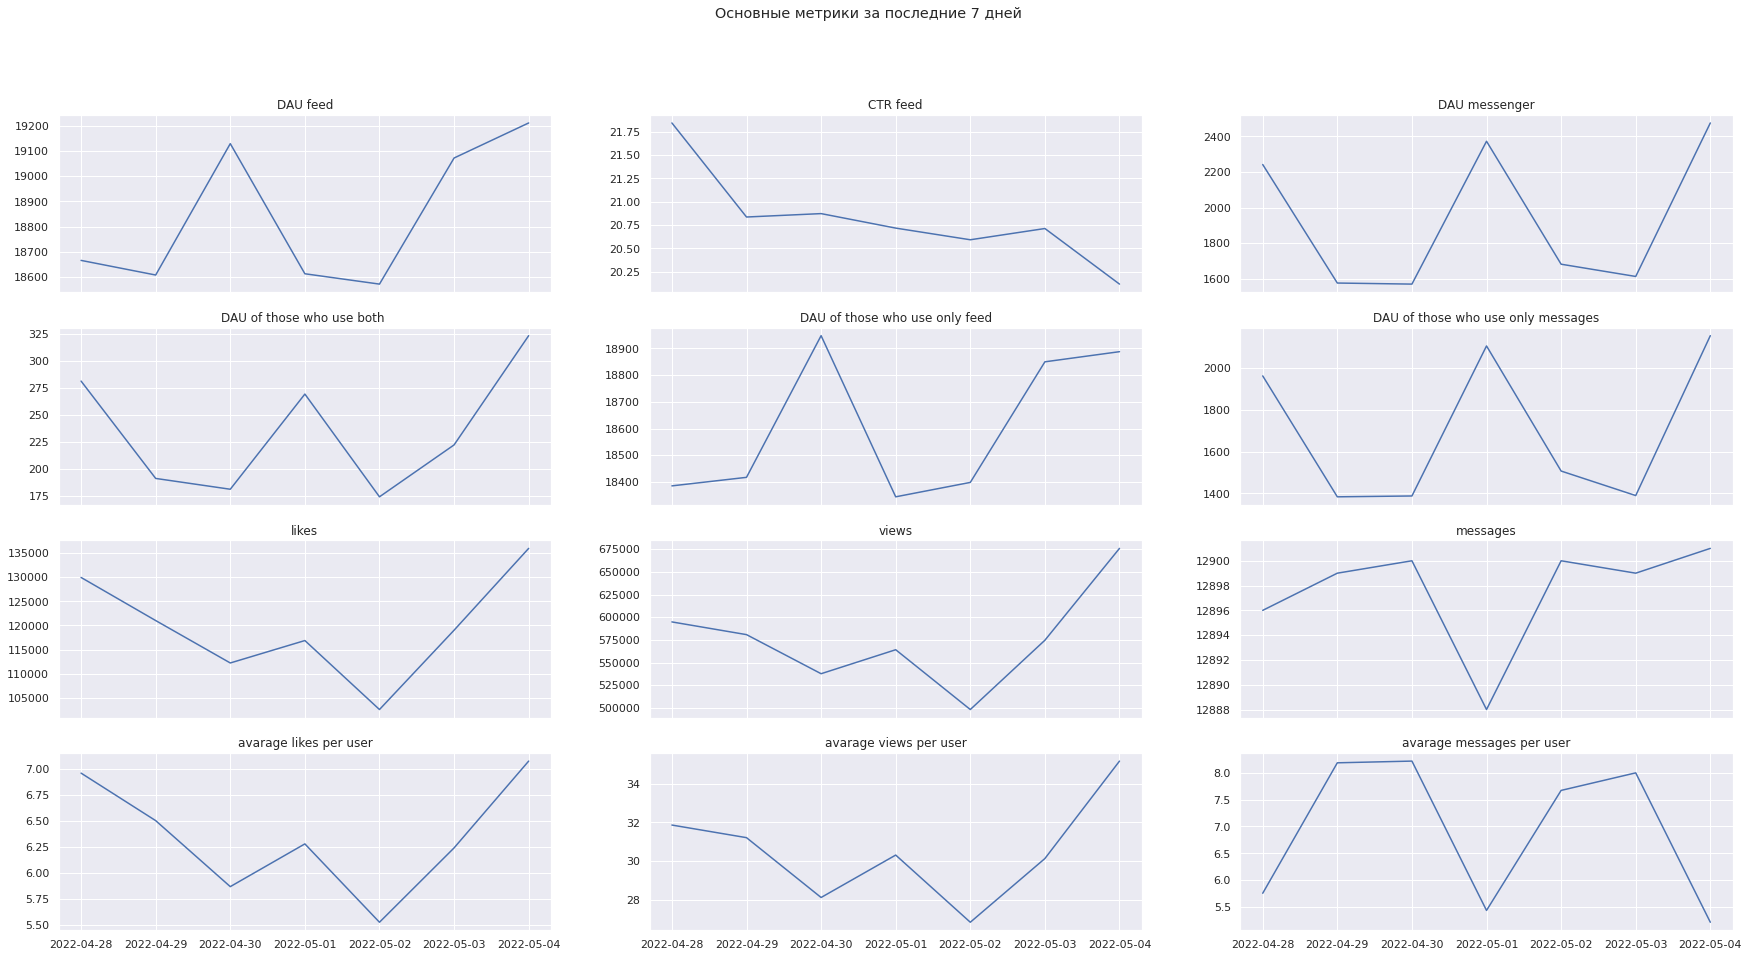

In [150]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(4, 3, figsize=(30,15), sharex=True)
fig.suptitle('Основные метрики за последние 7 дней')

axes[0,0].set_title('DAU feed')
axes[0,1].set_title('CTR feed')
axes[0,2].set_title('DAU messenger')

axes[1, 0].set_title('DAU of those who use both ')
axes[1, 1].set_title('DAU of those who use only feed')
axes[1, 2].set_title('DAU of those who use only messages')

axes[2, 0].set_title('likes')
axes[2, 1].set_title('views')
axes[2, 2].set_title('messages')

axes[3, 0].set_title('avarage likes per user')
axes[3, 1].set_title('avarage views per user')
axes[3, 2].set_title('avarage messages per user')

sns.lineplot(ax=axes[0, 0], x=df.day.values, y=df.cnt_feed_users.values)
sns.lineplot(ax=axes[0, 1], x=df.day.values, y=df.ctr.values)
sns.lineplot(ax=axes[0, 2], x=df.day.values, y=df.cnt_msg_users.values)

sns.lineplot(ax=axes[1, 0], x=df.day.values, y=df.using_all_products.values)
sns.lineplot(ax=axes[1, 1], x=df.day.values, y=df.using_only_feed.values)
sns.lineplot(ax=axes[1, 2], x=df.day.values, y=df.using_only_msg.values)

sns.lineplot(ax=axes[2, 0], x=df.day.values, y=df.likes.values)
sns.lineplot(ax=axes[2, 1], x=df.day.values, y=df.views.values)
sns.lineplot(ax=axes[2, 2], x=df.day.values, y=df.cnt_send_msg.values)


sns.lineplot(ax=axes[3, 0], x=df.day.values, y=df.avg_likes_per_user.values)
sns.lineplot(ax=axes[3, 1], x=df.day.values, y=df.avg_views_per_user.values)
sns.lineplot(ax=axes[3, 2], x=df.day.values, y=df.avg_msg_per_user.values)



# заведем файловый объект в буфере, в который будем сохранять график
plot_object = io.BytesIO() 

# сохраним график в файловый объект в буфере
plt.savefig(plot_object)
plot_object.name = 'расширенный отчет за последние 7 дней.png'

# перенесем курсор из конца файлового объекта в начало, чтобы потом читать весь файл
plot_object.seek(0)
plt.close()

In [149]:
file_object = io.StringIO()
df_all.to_csv(file_object)
file_object.seek(0)
file_object.name = 'Данные за все время.csv'

bot = telegram.Bot(token=connect.bot_token)#os.environ.get("bot_token"))

chat_id = connect.chat_id #os.environ.get("chat_id")

bot.sendMessage(chat_id=chat_id, text=f'''Последняя неделя по состоянию на {df.day.iloc[0].date()}. Исторические данные прикреплены в файле''')

# отпраавим графики с показателями за последние 7 дней
bot.sendPhoto(chat_id=chat_id, photo=plot_object)

# отпраавим данные с показателями за все время
bot.sendDocument(chat_id=chat_id, document=file_object)
               


    ______________________________
    2022-05-04T00:00:00.000000000:
    	DAU новостной ленты 19 211 | 	DAU мессенджера 2 476
    	просмотренно 675 874 | 	отлайкано: 135 958 |	посланно сообщений: 12 901

    


Тогда полный файл скрипта будет выглядеть как

In [ ]:
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import pandahouse

def report():

    # получим доступ к боту
    bot = telegram.Bot(token = os.environ.get("bot_token"))

    chat_id = os.environ.get("chat_id")


    connection = {
        'host': os.environ.get("db_host"),
        'password': os.environ.get("db_password"),
        'user': os.environ.get("db_login")
    }

    def db_to_dataframe(query, connection):
        """
        db_to_dataframe(query, connection=connection)
        возвращает объект DataFrame выгруженный из базы.
        Параметры подключения к базе определены в переменной connection
        """
        return pandahouse.read_clickhouse(query, connection=connection)

    query = '''
    with msg_users as(
    SELECT 
        DISTINCT user_id,
        CAST(time as DATE) day
    From simulator_20220420.message_actions),

    feed_users as(
        SELECT 
            DISTINCT user_id user_id,
            CAST(time as DATE) day
        FROM simulator_20220420.feed_actions),

    using_all AS(
        SELECT 
            t1.day day,
            COUNT (t2.user_id) cnt_using_all
        FROM msg_users as t1
        INNER JOIN feed_users as t2 ON (t1.user_id =t2.user_id
                                          and t1.day=t2.day)
        GROUP BY day
        ORDER BY day ASC),

    using_msg_only as(
        SELECT 
            t1.day day,
            COUNT (t1.user_id) cnt_using_only_msg
        FROM msg_users as t1
        LEFT JOIN feed_users as t2 ON (t1.user_id =t2.user_id
                                         and t1.day=t2.day)
        WHERE t2.day = '1970-01-01'
        GROUP BY day
        ORDER BY day ASC),

    using_feed_only as(
        SELECT 
            t2.day day,
            COUNT (t2.user_id) cnt_using_only_feed
        FROM msg_users as t1
        RIGHT  JOIN feed_users as t2 ON (t1.user_id =t2.user_id
                                           and t1.day=t2.day)
        WHERE t1.day = '1970-01-01'
        GROUP BY day
        ORDER BY day ASC) 

    SELECT
    tb2.*,
    tb1.using_all_products,
    tb1.using_only_msg,
    tb1.using_only_feed
    FROM    
    (SELECT 
        using_all.day day,
        using_all.cnt_using_all using_all_products,
        using_msg_only.cnt_using_only_msg using_only_msg,
        using_feed_only.cnt_using_only_feed using_only_feed
    FROM using_all
    left join using_msg_only ON using_all.day = using_msg_only.day
    LEFT JOIN using_feed_only ON using_all.day = using_feed_only.day
    WHERE 
        toStartOfDay(toDateTime(day))<toStartOfDay(now())

    Order By day desc)tb1
    LEFT JOIN
    (
    select
    t1.*,
    t2.cnt_msg_users,
    t2.cnt_send_msg,
    t2.avg_msg_per_user
    FROM
    (SELECT 
       CAST(toStartOfDay(toDateTime(time)) as DATE) AS day,
       count(Distinct user_id) AS cnt_feed_users,
       countIf(user_id, action='like') AS likes,
       countIf(user_id, action='view') AS views,
       likes/views*100 as ctr,
       likes/cnt_feed_users avg_likes_per_user,
       views/cnt_feed_users avg_views_per_user
    FROM 
        simulator_20220420.feed_actions
    WHERE 
        toStartOfDay(toDateTime(time))<toStartOfDay(now())

    GROUP BY
        toStartOfDay(toDateTime(time))
    ORDER BY day DESC
    )t1
    left join 
    (
    SELECT
    CAST (toStartOfDay(time) as DATE) day,
    count(DISTINCT user_id) cnt_msg_users,
    count(user_id) cnt_send_msg,
    cnt_send_msg/cnt_msg_users avg_msg_per_user
    FROM simulator_20220420.message_actions
    WHERE 
        toStartOfDay(toDateTime(time))<toStartOfDay(now())
    GROUP BY
        day
    ORDER BY day desc
    )t2 
    USING day
    )tb2
    USING day

    '''

    df_all = db_to_dataframe(query, connection).rename(columns={'tb2.day':'day'})
    df = df_all.head(7).copy()

    sns.set(style="darkgrid")
    fig, axes = plt.subplots(4, 3, figsize=(30,15), sharex=True)
    fig.suptitle('Основные метрики за последние 7 дней')

    axes[0,0].set_title('DAU feed')
    axes[0,1].set_title('CTR feed')
    axes[0,2].set_title('DAU messenger')

    axes[1, 0].set_title('DAU of those who use both ')
    axes[1, 1].set_title('DAU of those who use only feed')
    axes[1, 2].set_title('DAU of those who use only messages')

    axes[2, 0].set_title('likes')
    axes[2, 1].set_title('views')
    axes[2, 2].set_title('messages')

    axes[3, 0].set_title('avarage likes per user')
    axes[3, 1].set_title('avarage views per user')
    axes[3, 2].set_title('avarage messages per user')

    sns.lineplot(ax=axes[0, 0], x=df.day.values, y=df.cnt_feed_users.values)
    sns.lineplot(ax=axes[0, 1], x=df.day.values, y=df.ctr.values)
    sns.lineplot(ax=axes[0, 2], x=df.day.values, y=df.cnt_msg_users.values)

    sns.lineplot(ax=axes[1, 0], x=df.day.values, y=df.using_all_products.values)
    sns.lineplot(ax=axes[1, 1], x=df.day.values, y=df.using_only_feed.values)
    sns.lineplot(ax=axes[1, 2], x=df.day.values, y=df.using_only_msg.values)

    sns.lineplot(ax=axes[2, 0], x=df.day.values, y=df.likes.values)
    sns.lineplot(ax=axes[2, 1], x=df.day.values, y=df.views.values)
    sns.lineplot(ax=axes[2, 2], x=df.day.values, y=df.cnt_send_msg.values)


    sns.lineplot(ax=axes[3, 0], x=df.day.values, y=df.avg_likes_per_user.values)
    sns.lineplot(ax=axes[3, 1], x=df.day.values, y=df.avg_views_per_user.values)
    sns.lineplot(ax=axes[3, 2], x=df.day.values, y=df.avg_msg_per_user.values)



    # заведем файловый объект в буфере, в который будем сохранять график
    plot_object = io.BytesIO() 

    # сохраним график в файловый объект в буфере
    plt.savefig(plot_object)
    plot_object.name = 'расширенный отчет за последние 7 дней.png'

    # перенесем курсор из конца файлового объекта в начало, чтобы потом читать весь файл
    plot_object.seek(0)
    plt.close()
    
    file_object = io.StringIO()
    df_all.to_csv(file_object)
    file_object.seek(0)
    file_object.name = 'Данные за все время.csv'


    bot.sendMessage(chat_id=chat_id, text=f'''Последняя неделя по состоянию на {df.day.iloc[0].date()}. Исторические данные прикреплены в файле''')

    # отпраавим графики с показателями за последние 7 дней
    bot.sendPhoto(chat_id=chat_id, photo=plot_object)

    # отпраавим данные с показателями за все время
    bot.sendDocument(chat_id=chat_id, document=file_object)
try:
    report()
except Exception as e:
    print(e)
    



А yml файл

In [ ]:
image: cr.yandex/crp742p3qacifd2hcon2/practice-da:latest

stages:
    - full_report

job_1:
    stage: full_report
    only:
        - schedules
    script:
        - python full_report.py
